In [737]:
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split


In [738]:
#Limpieza del dataset como en TP1

oportunidades = pd.read_csv("Train_TP2_Datos_2020-2C.csv")
oportunidades['Account_Created_Date'] = pd.to_datetime(oportunidades['Account_Created_Date'])
oportunidades['Opportunity_Created_Date'] = pd.to_datetime(oportunidades['Opportunity_Created_Date'])
oportunidades['Quote_Expiry_Date'] = pd.to_datetime(oportunidades['Quote_Expiry_Date'])
oportunidades['Last_Modified_Date'] = pd.to_datetime(oportunidades['Last_Modified_Date'])
oportunidades['Planned_Delivery_Start_Date'] = pd.to_datetime(oportunidades['Planned_Delivery_Start_Date'])
oportunidades['Planned_Delivery_End_Date'] = pd.to_datetime(oportunidades['Planned_Delivery_End_Date'])
oportunidades_japon = (oportunidades.loc[oportunidades['Region'] == 'Japan'])
oportunidades = (oportunidades.loc[oportunidades['Region'] != 'Japan'])
#oportunidades_japon = oportunidades_japon.iloc[:,:3]
oportunidades_japon['Territory'] = oportunidades_japon['Territory'].replace({'None':'Japan'})
oportunidades = pd.concat([oportunidades, oportunidades_japon], axis=0)
oportunidades['Region'] = oportunidades['Region'].replace({'Japan':'APAC', 'Middle East':'EMEA'})
oportunidades[oportunidades.select_dtypes(['object']).columns] = oportunidades.select_dtypes(['object']).apply(lambda x: x.astype('category'))
oportunidades = oportunidades.loc[oportunidades['Territory'] != 'None']
oportunidades = oportunidades.dropna()
oportunidades["Moneda_Convertida"] = (oportunidades['ASP'] / oportunidades['ASP_(converted)'])
oportunidades

,ID,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Submitted_for_Approval,Bureaucratic_Code,Account_Created_Date,...,Delivery_Year,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A,Moneda_Convertida
2,27446,Americas,NW America,0,0,0,0,0,Bureaucratic_Code_4,2015-04-21,...,2016,NaT,0,USD,83865.6,USD,83865.6,Closed Won,Prod_Category_A_None,1.000000
4,16805,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,2013-07-27,...,2018,NaT,25,USD,13357192.5,USD,13357192.5,Closed Lost,Prod_Category_A_None,1.000000
5,16802,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,2013-07-27,...,2018,NaT,28,USD,14838277.5,USD,14838277.5,Closed Lost,Prod_Category_A_None,1.000000
7,27455,Americas,NW America,1,1,1,1,0,Bureaucratic_Code_4,2015-04-21,...,2016,NaT,0,USD,50688.0,USD,50688.0,Closed Won,Prod_Category_A_None,1.000000
23,28524,APAC,India,1,1,1,1,0,Bureaucratic_Code_4,2015-10-13,...,2016,NaT,3,USD,1621851.0,USD,1621851.0,Closed Won,Prod_Category_A_None,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16922,18519,APAC,Japan,1,1,1,1,0,Bureaucratic_Code_4,2013-07-28,...,2016,NaT,0,USD,13200.0,USD,6422400.6,Closed Won,Prod_Category_A_None,1.000000
16923,27689,APAC,Japan,1,1,0,0,0,Bureaucratic_Code_4,2015-06-11,...,2016,NaT,0,JPY,12194000.0,JPY,12194000.0,Closed Won,Prod_Category_A_None,111.229165
16924,27688,APAC,Japan,1,1,0,0,0,Bureaucratic_Code_4,2015-06-11,...,2016,NaT,0,JPY,11959500.0,JPY,11959500.0,Closed Won,Prod_Category_A_None,111.229165
16925,19062,APAC,Japan,0,0,0,0,0,Bureaucratic_Code_4,2013-08-11,...,2016,NaT,0,JPY,17537000.0,JPY,17537000.0,Closed Won,Prod_Category_A_None,111.229477


In [739]:
#Añadimos la columna binaria de si es aprobada o no.

filtro_terminos_entrega = oportunidades['Pricing, Delivery_Terms_Quote_Appr']\
     == oportunidades['Pricing, Delivery_Terms_Approved']

filtro_codigo_burocratico = oportunidades['Bureaucratic_Code_0_Approval']\
     == oportunidades['Bureaucratic_Code_0_Approved']

oportunidades = oportunidades.drop(['Pricing, Delivery_Terms_Quote_Appr'\
    ,'Pricing, Delivery_Terms_Approved', 'Bureaucratic_Code_0_Approval'\
        , 'Bureaucratic_Code_0_Approved', 'Submitted_for_Approval'], axis = 'columns')

oportunidades_posibles = (filtro_terminos_entrega & filtro_codigo_burocratico)

oportunidades.insert(3,'Es_Oportunidad_Posible', oportunidades_posibles)

oportunidades['Es_Oportunidad_Posible'] = oportunidades['Es_Oportunidad_Posible'].replace(
    {True:1, False:0})
oportunidades.head()

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Delivery_Year,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A,Moneda_Convertida
2,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,2016,NaT,0,USD,83865.6,USD,83865.6,Closed Won,Prod_Category_A_None,1.0
4,16805,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_851,...,2018,NaT,25,USD,13357192.5,USD,13357192.5,Closed Lost,Prod_Category_A_None,1.0
5,16802,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_939,...,2018,NaT,28,USD,14838277.5,USD,14838277.5,Closed Lost,Prod_Category_A_None,1.0
7,27455,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8227,...,2016,NaT,0,USD,50688.0,USD,50688.0,Closed Won,Prod_Category_A_None,1.0
23,28524,APAC,India,1,Bureaucratic_Code_4,2015-10-13,None,India,Account_Name_1147,Opportunity_Name_7036,...,2016,NaT,3,USD,1621851.0,USD,1621851.0,Closed Won,Prod_Category_A_None,1.0


In [740]:
#Encoding de los vendedores con mean encoding respecto del total amount.
encoding_owners = oportunidades.groupby('Opportunity_Owner').agg({'Total_Amount':'mean'})
encoding_owners.columns = ['Encoding_Vendedor']
encoding_owners = encoding_owners.reset_index()
oportunidades = oportunidades.merge(encoding_owners, how='inner', on='Opportunity_Owner')
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A,Moneda_Convertida,Encoding_Vendedor
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,NaT,0,USD,83865.6,USD,83865.6,Closed Won,Prod_Category_A_None,1.000000,2.232794e+06
1,16805,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_851,...,NaT,25,USD,13357192.5,USD,13357192.5,Closed Lost,Prod_Category_A_None,1.000000,2.232794e+06
2,16802,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_939,...,NaT,28,USD,14838277.5,USD,14838277.5,Closed Lost,Prod_Category_A_None,1.000000,2.232794e+06
3,27455,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8227,...,NaT,0,USD,50688.0,USD,50688.0,Closed Won,Prod_Category_A_None,1.000000,2.232794e+06
4,21750,Americas,NE America,1,Bureaucratic_Code_4,2013-07-27,Source_11,United States,Account_Name_25,Opportunity_Name_1814,...,NaT,0,USD,11961.6,USD,0.0,Closed Won,Prod_Category_A_None,1.000000,2.232794e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9720,28141,APAC,Japan,1,Bureaucratic_Code_4,2015-07-03,None,Japan,Account_Name_702,Opportunity_Name_4988,...,NaT,1,JPY,38976000.0,JPY,38976000.0,Closed Lost,Prod_Category_A_None,111.229550,5.688996e+07
9721,28084,APAC,Japan,1,Bureaucratic_Code_4,2015-07-03,None,Japan,Account_Name_702,Opportunity_Name_4989,...,NaT,1,JPY,56028000.0,JPY,56028000.0,Closed Lost,Prod_Category_A_None,111.229326,5.688996e+07
9722,28181,APAC,Japan,1,Bureaucratic_Code_1,2015-07-03,None,Japan,Account_Name_702,Opportunity_Name_4994,...,NaT,0,JPY,7660800.0,JPY,7660800.0,Closed Lost,Prod_Category_A_None,111.231449,5.688996e+07
9723,28182,APAC,Japan,1,Bureaucratic_Code_4,2015-07-03,None,Japan,Account_Name_702,Opportunity_Name_8661,...,NaT,0,JPY,825000.0,JPY,825000.0,Closed Won,Prod_Category_A_None,111.230206,5.688996e+07


In [741]:
#Encoding de los territorios en base al total amount
encoding_territory = oportunidades.groupby('Territory').agg({'Total_Amount' : 'mean'})
encoding_territory.columns = ['Encoding_Territorio']
encoding_territory = encoding_territory.reset_index()
oportunidades = oportunidades.merge(encoding_territory, how='inner', on='Territory')
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A,Moneda_Convertida,Encoding_Vendedor,Encoding_Territorio
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,0,USD,83865.6,USD,83865.6,Closed Won,Prod_Category_A_None,1.0,2.232794e+06,1.534896e+06
1,16805,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_851,...,25,USD,13357192.5,USD,13357192.5,Closed Lost,Prod_Category_A_None,1.0,2.232794e+06,1.534896e+06
2,16802,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_939,...,28,USD,14838277.5,USD,14838277.5,Closed Lost,Prod_Category_A_None,1.0,2.232794e+06,1.534896e+06
3,27455,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8227,...,0,USD,50688.0,USD,50688.0,Closed Won,Prod_Category_A_None,1.0,2.232794e+06,1.534896e+06
4,21527,Americas,NW America,1,Bureaucratic_Code_4,2013-07-27,Source_11,United States,Account_Name_25,Opportunity_Name_1828,...,0,USD,2814.0,USD,2814.0,Closed Won,Prod_Category_A_None,1.0,2.232794e+06,1.534896e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9720,14862,APAC,New Zealand,0,Bureaucratic_Code_5,2017-05-23,Source_7,New Zealand,Account_Name_1857,Opportunity_Name_11725,...,0,USD,28875.0,USD,147262.5,Closed Won,Prod_Category_A_None,1.0,3.610676e+06,3.498250e+04
9721,14868,APAC,New Zealand,0,Bureaucratic_Code_5,2017-05-23,Source_7,New Zealand,Account_Name_1857,Opportunity_Name_11725,...,0,USD,28875.0,USD,147262.5,Closed Won,Prod_Category_A_None,1.0,3.610676e+06,3.498250e+04
9722,14873,APAC,New Zealand,0,Bureaucratic_Code_5,2017-05-23,Source_7,New Zealand,Account_Name_1857,Opportunity_Name_11725,...,0,USD,28875.0,USD,147262.5,Closed Won,Prod_Category_A_None,1.0,3.610676e+06,3.498250e+04
9723,14879,APAC,New Zealand,0,Bureaucratic_Code_5,2017-05-23,Source_7,New Zealand,Account_Name_1857,Opportunity_Name_11725,...,0,USD,28875.0,USD,147262.5,Closed Won,Prod_Category_A_None,1.0,3.610676e+06,3.498250e+04


In [742]:
#Encoding de las regiones en base al total amount
encoding_region = oportunidades.groupby('Region').agg({'Total_Amount' : 'mean'})
encoding_region.columns = ['Encoding_Region']
encoding_region = encoding_region.reset_index()
oportunidades = oportunidades.merge(encoding_region, how='inner', on='Region')
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A,Moneda_Convertida,Encoding_Vendedor,Encoding_Territorio,Encoding_Region
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,USD,83865.6,USD,83865.6,Closed Won,Prod_Category_A_None,1.0,2.232794e+06,1.534896e+06,2.250980e+06
1,16805,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_851,...,USD,13357192.5,USD,13357192.5,Closed Lost,Prod_Category_A_None,1.0,2.232794e+06,1.534896e+06,2.250980e+06
2,16802,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_939,...,USD,14838277.5,USD,14838277.5,Closed Lost,Prod_Category_A_None,1.0,2.232794e+06,1.534896e+06,2.250980e+06
3,27455,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8227,...,USD,50688.0,USD,50688.0,Closed Won,Prod_Category_A_None,1.0,2.232794e+06,1.534896e+06,2.250980e+06
4,21527,Americas,NW America,1,Bureaucratic_Code_4,2013-07-27,Source_11,United States,Account_Name_25,Opportunity_Name_1828,...,USD,2814.0,USD,2814.0,Closed Won,Prod_Category_A_None,1.0,2.232794e+06,1.534896e+06,2.250980e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9720,14857,APAC,New Zealand,0,Bureaucratic_Code_5,2017-05-23,Source_7,New Zealand,Account_Name_1857,Opportunity_Name_11725,...,USD,31762.5,USD,147262.5,Closed Won,Prod_Category_A_None,1.0,3.610676e+06,3.498250e+04,2.951944e+06
9721,14862,APAC,New Zealand,0,Bureaucratic_Code_5,2017-05-23,Source_7,New Zealand,Account_Name_1857,Opportunity_Name_11725,...,USD,28875.0,USD,147262.5,Closed Won,Prod_Category_A_None,1.0,3.610676e+06,3.498250e+04,2.951944e+06
9722,14868,APAC,New Zealand,0,Bureaucratic_Code_5,2017-05-23,Source_7,New Zealand,Account_Name_1857,Opportunity_Name_11725,...,USD,28875.0,USD,147262.5,Closed Won,Prod_Category_A_None,1.0,3.610676e+06,3.498250e+04,2.951944e+06
9723,14873,APAC,New Zealand,0,Bureaucratic_Code_5,2017-05-23,Source_7,New Zealand,Account_Name_1857,Opportunity_Name_11725,...,USD,28875.0,USD,147262.5,Closed Won,Prod_Category_A_None,1.0,3.610676e+06,3.498250e+04,2.951944e+06


In [743]:
#Encoding del tipo de moneda en base al mean del ASP
encoding_moneda = oportunidades.groupby('Total_Amount_Currency').agg({'Moneda_Convertida' : 'mean'})
encoding_moneda.columns = ['Encoding_Moneda']
encoding_moneda = encoding_moneda.reset_index()
oportunidades = oportunidades.merge(encoding_moneda, how='inner', on='Total_Amount_Currency')

In [744]:
#Encoding del Bureaucratic_Code en base a Dummies
oportunidades = pd.concat([oportunidades, pd.get_dummies(oportunidades['Bureaucratic_Code'])], axis='columns')
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Encoding_Territorio,Encoding_Region,Encoding_Moneda,Bureaucratic_Code_0,Bureaucratic_Code_1,Bureaucratic_Code_2,Bureaucratic_Code_3,Bureaucratic_Code_4,Bureaucratic_Code_5,Bureaucratic_Code_6
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,1.534896e+06,2.250980e+06,1.000000,0,0,0,0,1,0,0
1,16805,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_851,...,1.534896e+06,2.250980e+06,1.000000,0,0,0,0,0,1,0
2,16802,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_939,...,1.534896e+06,2.250980e+06,1.000000,0,0,0,0,0,1,0
3,27455,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8227,...,1.534896e+06,2.250980e+06,1.000000,0,0,0,0,1,0,0
4,21527,Americas,NW America,1,Bureaucratic_Code_4,2013-07-27,Source_11,United States,Account_Name_25,Opportunity_Name_1828,...,1.534896e+06,2.250980e+06,1.000000,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9720,17555,APAC,Australia,1,Bureaucratic_Code_4,2013-10-03,None,Australia,Account_Name_1440,Opportunity_Name_10149,...,1.042592e+06,2.951944e+06,1.413202,0,0,0,0,1,0,0
9721,18413,APAC,Australia,1,Bureaucratic_Code_4,2013-07-28,None,Australia,Account_Name_1440,Opportunity_Name_10153,...,1.042592e+06,2.951944e+06,1.413202,0,0,0,0,1,0,0
9722,18416,APAC,Australia,1,Bureaucratic_Code_4,2013-07-28,None,Australia,Account_Name_1440,Opportunity_Name_10150,...,1.042592e+06,2.951944e+06,1.413202,0,0,0,0,1,0,0
9723,22188,APAC,Australia,1,Bureaucratic_Code_4,2014-09-19,Source_9,Australia,Account_Name_1642,Opportunity_Name_10445,...,1.042592e+06,2.951944e+06,1.413202,0,0,0,0,1,0,0


In [745]:
#Encoding del Billing Country en base a mean de Total_Amount.
encoding_bill_c = oportunidades.groupby('Billing_Country').agg({'Total_Amount' : 'mean'})
encoding_bill_c.columns = ['Encoding_Billing_Country']
encoding_bill_c = encoding_bill_c.reset_index()
oportunidades = oportunidades.merge(encoding_bill_c, how='inner', on='Billing_Country')
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Encoding_Region,Encoding_Moneda,Bureaucratic_Code_0,Bureaucratic_Code_1,Bureaucratic_Code_2,Bureaucratic_Code_3,Bureaucratic_Code_4,Bureaucratic_Code_5,Bureaucratic_Code_6,Encoding_Billing_Country
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,2.250980e+06,1.000000,0,0,0,0,1,0,0,2.245889e+06
1,16805,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_851,...,2.250980e+06,1.000000,0,0,0,0,0,1,0,2.245889e+06
2,16802,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_939,...,2.250980e+06,1.000000,0,0,0,0,0,1,0,2.245889e+06
3,27455,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8227,...,2.250980e+06,1.000000,0,0,0,0,1,0,0,2.245889e+06
4,21527,Americas,NW America,1,Bureaucratic_Code_4,2013-07-27,Source_11,United States,Account_Name_25,Opportunity_Name_1828,...,2.250980e+06,1.000000,0,0,0,0,1,0,0,2.245889e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9720,6773,EMEA,Malta,1,Bureaucratic_Code_4,2017-07-13,Source_13,Malta,Account_Name_600,Opportunity_Name_9426,...,8.201907e+05,0.884131,0,0,0,0,1,0,0,4.164458e+06
9721,6779,EMEA,Malta,1,Bureaucratic_Code_4,2017-07-13,Source_13,Malta,Account_Name_600,Opportunity_Name_9496,...,8.201907e+05,0.884131,0,0,0,0,1,0,0,4.164458e+06
9722,6790,EMEA,Malta,1,Bureaucratic_Code_4,2017-07-13,Source_13,Malta,Account_Name_600,Opportunity_Name_4195,...,8.201907e+05,0.884131,0,0,0,0,1,0,0,4.164458e+06
9723,6762,EMEA,Malta,1,Bureaucratic_Code_4,2017-07-13,Source_13,Malta,Account_Name_600,Opportunity_Name_4194,...,8.201907e+05,0.884131,0,0,0,0,1,0,0,4.164458e+06


In [746]:
#Encoding del Product_Family en base a mean de Total_Amount.
encoding_product_family = oportunidades.groupby('Product_Family').agg({'Total_Amount' : 'mean'})
encoding_product_family.columns = ['Encoding_Prod_Family']
encoding_product_family = encoding_product_family.reset_index()
oportunidades = oportunidades.merge(encoding_product_family, how='inner', on='Product_Family')
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Encoding_Moneda,Bureaucratic_Code_0,Bureaucratic_Code_1,Bureaucratic_Code_2,Bureaucratic_Code_3,Bureaucratic_Code_4,Bureaucratic_Code_5,Bureaucratic_Code_6,Encoding_Billing_Country,Encoding_Prod_Family
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,1.000000,0,0,0,0,1,0,0,2.245889e+06,69490.525
1,27442,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8543,...,1.000000,0,0,0,0,1,0,0,2.245889e+06,69490.525
2,15713,EMEA,Germany,1,Bureaucratic_Code_4,2013-07-27,None,Germany,Account_Name_1994,Opportunity_Name_12186,...,0.884131,0,0,0,0,1,0,0,8.585832e+05,69490.525
3,16744,EMEA,Spain,1,Bureaucratic_Code_4,2013-07-27,Source_11,Spain,Account_Name_59,Opportunity_Name_9433,...,0.884131,0,0,0,0,1,0,0,1.240120e+06,69490.525
4,15045,APAC,India,0,Bureaucratic_Code_5,2017-05-24,Source_7,India,Account_Name_1983,Opportunity_Name_12179,...,1.000000,0,0,0,0,0,1,0,9.806871e+05,69490.525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9720,9753,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_3358,...,1.000000,0,0,0,0,1,0,0,1.079523e+05,2197.250
9721,9992,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_2744,...,1.000000,0,0,0,0,1,0,0,1.079523e+05,369.600
9722,9859,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_3360,...,1.000000,0,0,0,0,1,0,0,1.079523e+05,2274.300
9723,9163,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_2741,...,1.000000,0,0,0,0,1,0,0,1.079523e+05,3456.000


In [747]:
#Encoding con Dummies de Account_Type

oportunidades = pd.concat([oportunidades, pd.get_dummies(oportunidades['Account_Type'])],axis='columns')
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Bureaucratic_Code_6,Encoding_Billing_Country,Encoding_Prod_Family,Account_Type_0,Account_Type_1,Account_Type_2,Account_Type_4,Account_Type_5,Account_Type_6,None
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,0,2.245889e+06,69490.525,0,0,0,0,1,0,0
1,27442,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8543,...,0,2.245889e+06,69490.525,0,0,0,0,1,0,0
2,15713,EMEA,Germany,1,Bureaucratic_Code_4,2013-07-27,None,Germany,Account_Name_1994,Opportunity_Name_12186,...,0,8.585832e+05,69490.525,1,0,0,0,0,0,0
3,16744,EMEA,Spain,1,Bureaucratic_Code_4,2013-07-27,Source_11,Spain,Account_Name_59,Opportunity_Name_9433,...,0,1.240120e+06,69490.525,1,0,0,0,0,0,0
4,15045,APAC,India,0,Bureaucratic_Code_5,2017-05-24,Source_7,India,Account_Name_1983,Opportunity_Name_12179,...,0,9.806871e+05,69490.525,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9720,9753,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_3358,...,0,1.079523e+05,2197.250,1,0,0,0,0,0,0
9721,9992,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_2744,...,0,1.079523e+05,369.600,1,0,0,0,0,0,0
9722,9859,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_3360,...,0,1.079523e+05,2274.300,1,0,0,0,0,0,0
9723,9163,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_2741,...,0,1.079523e+05,3456.000,1,0,0,0,0,0,0


In [748]:
#Encoding de Delivery Terms en base a Dummies
oportunidades = pd.concat([oportunidades,pd.get_dummies(oportunidades['Delivery_Terms'])],axis='columns')
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,None,Delivery_Terms_0,Delivery_Terms_1,Delivery_Terms_2,Delivery_Terms_3,Delivery_Terms_4,Delivery_Terms_5,Delivery_Terms_6,Delivery_Terms_7,Delivery_Terms_8
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,0,0,0,0,0,1,0,0,0,0
1,27442,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8543,...,0,0,0,0,0,1,0,0,0,0
2,15713,EMEA,Germany,1,Bureaucratic_Code_4,2013-07-27,None,Germany,Account_Name_1994,Opportunity_Name_12186,...,0,0,0,1,0,0,0,0,0,0
3,16744,EMEA,Spain,1,Bureaucratic_Code_4,2013-07-27,Source_11,Spain,Account_Name_59,Opportunity_Name_9433,...,0,0,0,1,0,0,0,0,0,0
4,15045,APAC,India,0,Bureaucratic_Code_5,2017-05-24,Source_7,India,Account_Name_1983,Opportunity_Name_12179,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9720,9753,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_3358,...,0,0,0,0,0,0,0,1,0,0
9721,9992,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_2744,...,0,0,0,0,0,0,0,1,0,0
9722,9859,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_3360,...,0,0,0,0,0,0,0,1,0,0
9723,9163,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_2741,...,0,0,0,0,0,0,0,1,0,0


In [749]:
#Obtenemos el año de creación de la oportunidad como columna.
oportunidades['Opportunity_Created_Year'] = (oportunidades['Opportunity_Created_Date'].dt.year)
oportunidades['Opportunity_Created_Month'] = (oportunidades['Opportunity_Created_Date'].dt.month).replace({1:'01',2:'02',3:'03',4:'04',5:'05',6:'06',7:'07',8:'08',9:'09'})
oportunidades['Año_Por_Mes'] = ((oportunidades['Opportunity_Created_Year']).astype(str) \
    + (oportunidades['Opportunity_Created_Month']).astype(str)).astype(int)
oportunidades['Año_Por_Mes']

0       201512
1       201604
2       201712
3       201801
4       201706
         ...  
9720    201712
9721    201803
9722    201804
9723    201806
9724    201806
Name: Año_Por_Mes, Length: 9725, dtype: int32

In [750]:
oportunidades.columns


Index(['ID', 'Region', 'Territory', 'Es_Oportunidad_Posible',
       'Bureaucratic_Code', 'Account_Created_Date', 'Source ',
       'Billing_Country', 'Account_Name', 'Opportunity_Name', 'Opportunity_ID',
       'Sales_Contract_No', 'Account_Owner', 'Opportunity_Owner',
       'Account_Type', 'Opportunity_Type', 'Quote_Type', 'Delivery_Terms',
       'Opportunity_Created_Date', 'Brand', 'Product_Type', 'Size',
       'Product_Category_B', 'Price', 'Currency', 'Last_Activity',
       'Quote_Expiry_Date', 'Last_Modified_Date', 'Last_Modified_By',
       'Product_Family', 'Product_Name', 'ASP_Currency', 'ASP',
       'ASP_(converted)_Currency', 'ASP_(converted)',
       'Planned_Delivery_Start_Date', 'Planned_Delivery_End_Date', 'Month',
       'Delivery_Quarter', 'Delivery_Year', 'Actual_Delivery_Date', 'TRF',
       'Total_Amount_Currency', 'Total_Amount',
       'Total_Taxable_Amount_Currency', 'Total_Taxable_Amount', 'Stage',
       'Prod_Category_A', 'Moneda_Convertida', 'Encoding_Ve

In [751]:
oportunidades['Delivery_Quarter_Encoding'] = oportunidades['Delivery_Quarter']
oportunidades['Delivery_Quarter_Encoding'] = oportunidades['Delivery_Quarter_Encoding'].replace({'Q1': 1 , 'Q2':2, 'Q3': 3, 'Q4':4})
oportunidades['Delivery_Quarter_Encoding'].value_counts()


2    2581
3    2415
4    2410
1    2319
Name: Delivery_Quarter_Encoding, dtype: int64

In [752]:
#Una vez que tenemos el dataset limpio como en el TP1, iniciamos con el uso de XGBoost como algoritmo de ML.

#Parametros resultantes del tuning:{'objective': 'reg:logistic', 'max_depth': 7, 'n_estimators': 140, 
#'colsample_bytree': 0.9, 'subsample': 0.9, 'learning_rate': 0.085, 'alpha': 0.01, 'gamma': 0.2}

#Con Error: 0.3574255624906347

params = {
    'objective':'reg:logistic',
    'max_depth':7,
    'n_estimators':450,
    'colsample_bytree':0.4,
    'subsample':0.6,
    'learning_rate':0.02,
    'alpha':0.001,
    #'gamma':0.2
}

params2 = {
    'objective':'reg:logistic',
    'max_depth':8,
    'n_estimators':350,
    'colsample_bytree':0.4,
    'subsample':0.6,
    'learning_rate':0.02,
    'alpha':0.01,
    #'gamma':0.2
}

#xg_reg = xgb.XGBRegressor(objective =params['objective'], 
#                colsample_bytree = params['colsample_bytree'], learning_rate = params['learning_rate'],
#                max_depth = params['max_depth'], alpha = params['alpha'], n_estimators = params['n_estimators'], 
#                gamma = params['gamma'], subsample = params['subsample'])
xg_reg = xgb.XGBRegressor(objective =params['objective'], 
                colsample_bytree = params['colsample_bytree'], learning_rate = params['learning_rate'],
                max_depth = params['max_depth'], alpha = params['alpha'], n_estimators = params['n_estimators'], 
                subsample = params['subsample'])

xg_reg2 = xgb.XGBRegressor(objective =params2['objective'], 
                colsample_bytree = params2['colsample_bytree'], learning_rate = params2['learning_rate'],
                max_depth = params2['max_depth'], alpha = params2['alpha'], n_estimators = params2['n_estimators'], 
                subsample = params2['subsample'])
cat_reg = CatBoostRegressor(border_count = 6, depth = 8, iterations = 1000, l2_leaf_reg = 1, \
                            learning_rate = 0.012, random_strength = 0.9)

y_train = oportunidades['Stage']
oportunidades = oportunidades.loc[(oportunidades['Stage'] == 'Closed Won') | (oportunidades['Stage'] == 'Closed Lost')]
oportunidades['Stage'] = oportunidades['Stage'].replace({'Closed Won': 1, 'Closed Lost': 0})
# std_deviation_amounts = oportunidades.groupby('Opportunity_ID').agg({'TRF':'std'})
# std_deviation_amounts.columns = ['TRF_Std']
# std_deviation_amounts = std_deviation_amounts.reset_index()

#Solo usamos Bureau_Code_ 0,1,2,4,5 porque son los que tiene el set de test.
x_train = oportunidades.groupby('Opportunity_ID').agg({'Año_Por_Mes' : 'mean',\
                                                       'TRF': 'mean',\
                                                      'Encoding_Moneda':'mean',\
                                                      'Total_Amount': 'sum',\
                                                      'Total_Taxable_Amount':'mean',\
                                                      #'Encoding_Region':'mean',\
                                                      'Encoding_Territorio':'mean',\
                                                      'Encoding_Vendedor':'mean',\
                                                      'Es_Oportunidad_Posible':'mean',\
                                                       'Stage':'max',\
                                                       #'Encoding_Billing_Country':'mean',\
                                                      'Encoding_Prod_Family':'mean',\
                                                       'Delivery_Quarter_Encoding': 'mean'
                                                      })

#x_train = oportunidades.groupby('Opportunity_ID').agg({'Año_Por_Mes' : 'mean',\
 #                                                      'TRF': 'mean',\
  #                                                    'Encoding_Moneda':'mean', 'Total_Amount': 'sum',\
   #                                                   'Total_Taxable_Amount':'mean', 'Encoding_Region':'mean',\
    #                                                  'Encoding_Territorio':'mean','Encoding_Vendedor':'mean',\
     #                                                 'Es_Oportunidad_Posible':'mean','Stage':'max',
       #                                               'Bureaucratic_Code_0':'mean','Bureaucratic_Code_1':'mean',\
      #                                                'Bureaucratic_Code_2':'mean','Bureaucratic_Code_4':'mean',
        #                                              'Bureaucratic_Code_5':'mean', 'Encoding_Billing_Country':'mean',\
         #                                             'Delivery_Terms_0':'mean','Delivery_Terms_1':'mean','Delivery_Terms_2':'mean',\
          #                                            'Delivery_Terms_3':'mean','Delivery_Terms_4':'mean','Delivery_Terms_5':'mean',\
           #                                           'Delivery_Terms_6':'mean','Delivery_Terms_7':'mean','Delivery_Terms_8':'mean',
            #                                          'Encoding_Prod_Family':'mean','Account_Type_0':'mean','Account_Type_1':'mean',\
             #                                         'Account_Type_2':'mean','Account_Type_4':'mean', 'Account_Type_5':'mean'})

x_train = x_train.reset_index()
#x_train = x_train.merge(std_deviation_amounts, on='Opportunity_ID', how='inner')
x_train = x_train.set_index('Opportunity_ID')
y_train = x_train['Stage']
x_train = x_train.drop('Stage', axis='columns')
#x_train['Total_Amount_Std'] = x_train['Total_Amount_Std'].replace({np.nan:0})
x_train['Total_Amount'] = (x_train['Total_Amount'] / x_train['Encoding_Moneda']) 
x_train['Total_Taxable_Amount'] = (x_train['Total_Taxable_Amount'] / x_train['Encoding_Moneda']) 
x_train['Diferencia_Amounts'] = (x_train['Total_Amount'] - x_train['Total_Taxable_Amount'])
x_train = x_train.drop(columns = ['Encoding_Moneda'])
x_train['Vendedor_Por_Territorio'] = x_train['Encoding_Vendedor']*x_train['Encoding_Territorio']
#x_train['Total_Tax_Amount_Std'] = x_train['Total_Tax_Amount_Std'].replace({np.nan:0})
#x_train['TRF_Std'] = x_train['TRF_Std'].replace({np.nan:0})

<ipython-input-752-6fee20b2b307>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oportunidades['Stage'] = oportunidades['Stage'].replace({'Closed Won': 1, 'Closed Lost': 0})


In [753]:
#Entrenamos al xgboost
xg_reg.fit(x_train, y_train)

xg_reg2.fit(x_train, y_train)

cat_reg.fit(x_train, y_train)

data_dmatrix = xgb.DMatrix(data=x_train,label=y_train)

#xgb.cv(dtrain=data_dmatrix, params=params, nfold=20,
#        num_boost_round=params['n_estimators'], early_stopping_rounds=10,
#        metrics="rmse", as_pandas=True, seed=123)

0:	learn: 0.4914311	total: 3.09ms	remaining: 3.08s
1:	learn: 0.4897197	total: 5.78ms	remaining: 2.88s
2:	learn: 0.4879563	total: 8.4ms	remaining: 2.79s
3:	learn: 0.4866210	total: 10.1ms	remaining: 2.52s
4:	learn: 0.4851492	total: 12.1ms	remaining: 2.42s
5:	learn: 0.4834553	total: 14.6ms	remaining: 2.42s
6:	learn: 0.4818175	total: 17.2ms	remaining: 2.44s
7:	learn: 0.4801872	total: 20.3ms	remaining: 2.51s
8:	learn: 0.4785905	total: 23.2ms	remaining: 2.55s
9:	learn: 0.4769640	total: 25.7ms	remaining: 2.54s
10:	learn: 0.4754457	total: 28.2ms	remaining: 2.54s
11:	learn: 0.4739871	total: 32.9ms	remaining: 2.71s
12:	learn: 0.4724783	total: 36.5ms	remaining: 2.77s
13:	learn: 0.4710144	total: 39.8ms	remaining: 2.8s
14:	learn: 0.4695829	total: 42.7ms	remaining: 2.8s
15:	learn: 0.4681337	total: 45.5ms	remaining: 2.8s
16:	learn: 0.4667050	total: 48.5ms	remaining: 2.8s
17:	learn: 0.4653646	total: 51.5ms	remaining: 2.81s
18:	learn: 0.4639722	total: 54ms	remaining: 2.79s
19:	learn: 0.4626577	total: 5

162:	learn: 0.3891402	total: 523ms	remaining: 2.68s
163:	learn: 0.3889764	total: 527ms	remaining: 2.68s
164:	learn: 0.3887632	total: 531ms	remaining: 2.69s
165:	learn: 0.3885168	total: 535ms	remaining: 2.69s
166:	learn: 0.3883129	total: 545ms	remaining: 2.72s
167:	learn: 0.3881094	total: 549ms	remaining: 2.72s
168:	learn: 0.3879082	total: 553ms	remaining: 2.72s
169:	learn: 0.3877437	total: 557ms	remaining: 2.72s
170:	learn: 0.3875702	total: 561ms	remaining: 2.72s
171:	learn: 0.3873826	total: 565ms	remaining: 2.72s
172:	learn: 0.3872188	total: 569ms	remaining: 2.72s
173:	learn: 0.3870788	total: 575ms	remaining: 2.73s
174:	learn: 0.3869372	total: 578ms	remaining: 2.73s
175:	learn: 0.3868251	total: 582ms	remaining: 2.73s
176:	learn: 0.3866274	total: 586ms	remaining: 2.72s
177:	learn: 0.3864896	total: 589ms	remaining: 2.72s
178:	learn: 0.3863031	total: 592ms	remaining: 2.72s
179:	learn: 0.3861567	total: 596ms	remaining: 2.72s
180:	learn: 0.3859724	total: 600ms	remaining: 2.71s
181:	learn: 

353:	learn: 0.3667267	total: 1.21s	remaining: 2.21s
354:	learn: 0.3666616	total: 1.21s	remaining: 2.2s
355:	learn: 0.3665611	total: 1.22s	remaining: 2.2s
356:	learn: 0.3664733	total: 1.22s	remaining: 2.2s
357:	learn: 0.3663807	total: 1.22s	remaining: 2.19s
358:	learn: 0.3662976	total: 1.23s	remaining: 2.19s
359:	learn: 0.3662214	total: 1.23s	remaining: 2.19s
360:	learn: 0.3661532	total: 1.23s	remaining: 2.18s
361:	learn: 0.3660730	total: 1.24s	remaining: 2.18s
362:	learn: 0.3659832	total: 1.24s	remaining: 2.18s
363:	learn: 0.3659152	total: 1.25s	remaining: 2.18s
364:	learn: 0.3658591	total: 1.25s	remaining: 2.17s
365:	learn: 0.3658196	total: 1.25s	remaining: 2.17s
366:	learn: 0.3657401	total: 1.26s	remaining: 2.17s
367:	learn: 0.3656639	total: 1.26s	remaining: 2.16s
368:	learn: 0.3655882	total: 1.26s	remaining: 2.16s
369:	learn: 0.3654769	total: 1.27s	remaining: 2.16s
370:	learn: 0.3653813	total: 1.27s	remaining: 2.15s
371:	learn: 0.3653272	total: 1.27s	remaining: 2.15s
372:	learn: 0.3

556:	learn: 0.3524859	total: 1.9s	remaining: 1.51s
557:	learn: 0.3524231	total: 1.9s	remaining: 1.51s
558:	learn: 0.3523499	total: 1.91s	remaining: 1.5s
559:	learn: 0.3523174	total: 1.91s	remaining: 1.5s
560:	learn: 0.3522628	total: 1.91s	remaining: 1.5s
561:	learn: 0.3521856	total: 1.92s	remaining: 1.49s
562:	learn: 0.3521450	total: 1.92s	remaining: 1.49s
563:	learn: 0.3521185	total: 1.92s	remaining: 1.49s
564:	learn: 0.3520641	total: 1.93s	remaining: 1.48s
565:	learn: 0.3519868	total: 1.93s	remaining: 1.48s
566:	learn: 0.3519506	total: 1.93s	remaining: 1.48s
567:	learn: 0.3518882	total: 1.94s	remaining: 1.47s
568:	learn: 0.3518384	total: 1.94s	remaining: 1.47s
569:	learn: 0.3517593	total: 1.94s	remaining: 1.46s
570:	learn: 0.3517020	total: 1.94s	remaining: 1.46s
571:	learn: 0.3516318	total: 1.95s	remaining: 1.46s
572:	learn: 0.3515512	total: 1.95s	remaining: 1.46s
573:	learn: 0.3514924	total: 1.96s	remaining: 1.45s
574:	learn: 0.3514569	total: 1.96s	remaining: 1.45s
575:	learn: 0.351

754:	learn: 0.3411688	total: 2.58s	remaining: 838ms
755:	learn: 0.3411153	total: 2.58s	remaining: 834ms
756:	learn: 0.3410581	total: 2.59s	remaining: 831ms
757:	learn: 0.3409902	total: 2.59s	remaining: 827ms
758:	learn: 0.3409469	total: 2.59s	remaining: 824ms
759:	learn: 0.3408909	total: 2.6s	remaining: 821ms
760:	learn: 0.3408207	total: 2.6s	remaining: 817ms
761:	learn: 0.3407700	total: 2.6s	remaining: 814ms
762:	learn: 0.3407303	total: 2.61s	remaining: 810ms
763:	learn: 0.3406861	total: 2.61s	remaining: 807ms
764:	learn: 0.3406470	total: 2.62s	remaining: 804ms
765:	learn: 0.3406012	total: 2.62s	remaining: 800ms
766:	learn: 0.3405560	total: 2.62s	remaining: 797ms
767:	learn: 0.3404880	total: 2.63s	remaining: 793ms
768:	learn: 0.3404267	total: 2.63s	remaining: 790ms
769:	learn: 0.3403521	total: 2.63s	remaining: 786ms
770:	learn: 0.3403011	total: 2.64s	remaining: 783ms
771:	learn: 0.3402313	total: 2.64s	remaining: 780ms
772:	learn: 0.3401803	total: 2.64s	remaining: 777ms
773:	learn: 0.3

959:	learn: 0.3300368	total: 3.27s	remaining: 136ms
960:	learn: 0.3299910	total: 3.27s	remaining: 133ms
961:	learn: 0.3299414	total: 3.28s	remaining: 129ms
962:	learn: 0.3298784	total: 3.28s	remaining: 126ms
963:	learn: 0.3298229	total: 3.29s	remaining: 123ms
964:	learn: 0.3297780	total: 3.29s	remaining: 119ms
965:	learn: 0.3297159	total: 3.29s	remaining: 116ms
966:	learn: 0.3296641	total: 3.3s	remaining: 112ms
967:	learn: 0.3296179	total: 3.3s	remaining: 109ms
968:	learn: 0.3295615	total: 3.3s	remaining: 106ms
969:	learn: 0.3295172	total: 3.31s	remaining: 102ms
970:	learn: 0.3294602	total: 3.31s	remaining: 98.8ms
971:	learn: 0.3294200	total: 3.31s	remaining: 95.4ms
972:	learn: 0.3293805	total: 3.32s	remaining: 92ms
973:	learn: 0.3293257	total: 3.32s	remaining: 88.6ms
974:	learn: 0.3292882	total: 3.33s	remaining: 85.3ms
975:	learn: 0.3292389	total: 3.33s	remaining: 81.9ms
976:	learn: 0.3291837	total: 3.33s	remaining: 78.5ms
977:	learn: 0.3291305	total: 3.34s	remaining: 75.1ms
978:	lear

In [754]:
#Limpieza del dataset de test

oportunidades = pd.read_csv("Test_TP2_Datos_2020-2C.csv")
oportunidades['Account_Created_Date'] = pd.to_datetime(oportunidades['Account_Created_Date'])
oportunidades['Opportunity_Created_Date'] = pd.to_datetime(oportunidades['Opportunity_Created_Date'])
oportunidades['Quote_Expiry_Date'] = pd.to_datetime(oportunidades['Quote_Expiry_Date'])
oportunidades['Last_Modified_Date'] = pd.to_datetime(oportunidades['Last_Modified_Date'])
oportunidades['Planned_Delivery_Start_Date'] = pd.to_datetime(oportunidades['Planned_Delivery_Start_Date'])
oportunidades['Planned_Delivery_End_Date'] = pd.to_datetime(oportunidades['Planned_Delivery_End_Date'])
oportunidades_japon = (oportunidades.loc[oportunidades['Region'] == 'Japan'])
oportunidades = (oportunidades.loc[oportunidades['Region'] != 'Japan'])
#oportunidades_japon = oportunidades_japon.iloc[:,:3]
oportunidades_japon['Territory'] = oportunidades_japon['Territory'].replace({'None':'Japan'})
oportunidades = pd.concat([oportunidades, oportunidades_japon], axis=0)
oportunidades['Region'] = oportunidades['Region'].replace({'Japan':'APAC', 'Middle East':'EMEA'})
oportunidades[oportunidades.select_dtypes(['object']).columns] = oportunidades.select_dtypes(['object']).apply(lambda x: x.astype('category'))
#oportunidades = oportunidades.loc[oportunidades['Territory'] != 'None']
#oportunidades = oportunidades.dropna()

filtro_terminos_entrega = oportunidades['Pricing, Delivery_Terms_Quote_Appr']\
     == oportunidades['Pricing, Delivery_Terms_Approved']

filtro_codigo_burocratico = oportunidades['Bureaucratic_Code_0_Approval']\
     == oportunidades['Bureaucratic_Code_0_Approved']

oportunidades = oportunidades.drop(['Pricing, Delivery_Terms_Quote_Appr'\
    ,'Pricing, Delivery_Terms_Approved', 'Bureaucratic_Code_0_Approval'\
        , 'Bureaucratic_Code_0_Approved', 'Submitted_for_Approval'], axis = 'columns')

oportunidades["Moneda_Convertida"] = (oportunidades['ASP'] / oportunidades['ASP_(converted)'])
oportunidades_posibles = (filtro_terminos_entrega & filtro_codigo_burocratico)

oportunidades.insert(3,'Es_Oportunidad_Posible', oportunidades_posibles)

oportunidades['Es_Oportunidad_Posible'] = oportunidades['Es_Oportunidad_Posible'].replace(
    {True:1, False:0})

oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Delivery_Quarter,Delivery_Year,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Prod_Category_A,Moneda_Convertida
0,6140,EMEA,Germany,1,Bureaucratic_Code_4,2017-07-05,Source_7,Germany,Account_Name_978,Opportunity_Name_6118,...,Q2,2019,NaT,0,EUR,162240.0,EUR,367419.0,Prod_Category_A_None,0.884089
1,6146,EMEA,Germany,1,Bureaucratic_Code_4,2017-07-05,Source_7,Germany,Account_Name_978,Opportunity_Name_6118,...,Q2,2019,NaT,0,EUR,78624.0,EUR,367419.0,Prod_Category_A_None,0.884100
2,6151,EMEA,Germany,1,Bureaucratic_Code_4,2017-07-05,Source_7,Germany,Account_Name_978,Opportunity_Name_6118,...,Q2,2019,NaT,0,EUR,126555.0,EUR,367419.0,Prod_Category_A_None,0.884102
3,6118,EMEA,Germany,1,Bureaucratic_Code_4,2017-07-05,Source_7,Germany,Account_Name_978,Opportunity_Name_6117,...,Q2,2019,NaT,1,EUR,243360.0,EUR,757783.5,Prod_Category_A_None,0.884089
4,6124,EMEA,Germany,1,Bureaucratic_Code_4,2017-07-05,Source_7,Germany,Account_Name_978,Opportunity_Name_6117,...,Q2,2019,NaT,0,EUR,157248.0,EUR,757783.5,Prod_Category_A_None,0.884100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2512,15649,APAC,Japan,1,Bureaucratic_Code_4,2016-12-09,None,Japan,Account_Name_1039,Opportunity_Name_2761,...,Q2,2019,NaT,0,JPY,30000.0,JPY,73200.0,Prod_Category_A_None,NaN
2513,15655,APAC,Japan,1,Bureaucratic_Code_4,2016-12-09,None,Japan,Account_Name_1039,Opportunity_Name_2761,...,Q2,2019,NaT,0,JPY,43200.0,JPY,73200.0,Prod_Category_A_None,111.228519
2537,18605,APAC,Japan,1,Bureaucratic_Code_4,2013-07-28,Source_3,Japan,Account_Name_1075,Opportunity_Name_6475,...,Q3,2020,NaT,12,USD,4079928.6,USD,4079928.6,Prod_Category_A_None,1.000000
2542,5817,APAC,Japan,1,Bureaucratic_Code_4,2017-06-30,None,Japan,Account_Name_1542,Opportunity_Name_7265,...,Q3,2019,NaT,0,JPY,5068800.0,JPY,5068800.0,Prod_Category_A_None,111.229081


In [755]:
#Encoding para el dataset de testeo, con los mismos que en training set.

encoding_owners = oportunidades.groupby('Opportunity_Owner').agg({'Total_Amount':'mean'})
encoding_owners.columns = ['Encoding_Vendedor']
encoding_owners = encoding_owners.reset_index()
oportunidades = oportunidades.merge(encoding_owners, how='inner', on='Opportunity_Owner')

encoding_territory = oportunidades.groupby('Territory').agg({'Total_Amount' : 'mean'})
encoding_territory.columns = ['Encoding_Territorio']
encoding_territory = encoding_territory.reset_index()
oportunidades = oportunidades.merge(encoding_territory, how='inner', on='Territory')

encoding_region = oportunidades.groupby('Region').agg({'Total_Amount' : 'mean'})
encoding_region.columns = ['Encoding_Region']
encoding_region = encoding_region.reset_index()
oportunidades = oportunidades.merge(encoding_region, how='inner', on='Region')

encoding_moneda = oportunidades.groupby('Total_Amount_Currency').agg({'Moneda_Convertida' : 'mean'})
encoding_moneda.columns = ['Encoding_Moneda']
encoding_moneda = encoding_moneda.reset_index()
oportunidades = oportunidades.merge(encoding_moneda, how='inner', on='Total_Amount_Currency')
oportunidades

oportunidades = pd.concat([oportunidades, pd.get_dummies(oportunidades['Bureaucratic_Code'])],axis='columns')

encoding_bill_c = oportunidades.groupby('Billing_Country').agg({'Total_Amount' : 'mean'})
encoding_bill_c.columns = ['Encoding_Billing_Country']
encoding_bill_c = encoding_bill_c.reset_index()
oportunidades = oportunidades.merge(encoding_bill_c, how='inner', on='Billing_Country')
oportunidades

oportunidades = pd.concat([oportunidades, pd.get_dummies(oportunidades['Account_Type'])],axis='columns')

oportunidades = pd.concat([oportunidades,pd.get_dummies(oportunidades['Delivery_Terms'])],axis='columns')

encoding_product_family = oportunidades.groupby('Product_Family').agg({'Total_Amount' : 'mean'})
encoding_product_family.columns = ['Encoding_Prod_Family']
encoding_product_family = encoding_product_family.reset_index()
oportunidades = oportunidades.merge(encoding_product_family, how='inner', on='Product_Family')


oportunidades['Opportunity_Created_Year'] = (oportunidades['Opportunity_Created_Date'].dt.year)
oportunidades['Opportunity_Created_Month'] = (oportunidades['Opportunity_Created_Date'].dt.month).replace({1:'01',2:'02',3:'03',4:'04',5:'05',6:'06',7:'07',8:'08',9:'09'})
oportunidades['Año_Por_Mes'] = ((oportunidades['Opportunity_Created_Year']).astype(str) \
    + (oportunidades['Opportunity_Created_Month']).astype(str)).astype(int)
oportunidades['Año_Por_Mes']

oportunidades['Delivery_Quarter_Encoding'] = oportunidades['Delivery_Quarter']
oportunidades['Delivery_Quarter_Encoding'] = oportunidades['Delivery_Quarter_Encoding'].replace({'Q1': 1 , 'Q2':2, 'Q3': 3, 'Q4':4})
oportunidades


,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Delivery_Terms_4,Delivery_Terms_5,Delivery_Terms_6,Delivery_Terms_7,Delivery_Terms_8,Encoding_Prod_Family,Opportunity_Created_Year,Opportunity_Created_Month,Año_Por_Mes,Delivery_Quarter_Encoding
0,6140,EMEA,Germany,1,Bureaucratic_Code_4,2017-07-05,Source_7,Germany,Account_Name_978,Opportunity_Name_6118,...,0,0,0,0,0,1.347805e+07,2019,04,201904,2
1,6118,EMEA,Germany,1,Bureaucratic_Code_4,2017-07-05,Source_7,Germany,Account_Name_978,Opportunity_Name_6117,...,0,0,0,0,0,1.347805e+07,2019,04,201904,2
2,18450,EMEA,Germany,1,Bureaucratic_Code_4,2013-07-27,Source_9,Germany,Account_Name_533,Opportunity_Name_3499,...,0,0,0,0,0,1.347805e+07,2019,01,201901,3
3,18307,EMEA,Germany,0,Bureaucratic_Code_5,2013-07-27,Source_9,Germany,Account_Name_533,Opportunity_Name_4292,...,0,0,0,0,0,1.347805e+07,2019,02,201902,2
4,14441,EMEA,Germany,1,Bureaucratic_Code_4,2013-07-27,Source_7,Germany,Account_Name_263,Opportunity_Name_2981,...,0,0,0,0,0,1.347805e+07,2019,03,201903,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2546,11918,APAC,Japan,1,Bureaucratic_Code_4,2019-03-11,None,Japan,Account_Name_1533,Opportunity_Name_9046,...,0,0,1,0,0,3.300000e+05,2019,03,201903,1
2547,11379,APAC,Japan,0,Bureaucratic_Code_5,2019-02-12,None,Japan,Account_Name_1377,Opportunity_Name_12892,...,1,0,0,0,0,1.351350e+08,2019,04,201904,4
2548,6071,APAC,Japan,1,Bureaucratic_Code_4,2015-12-21,None,Japan,Account_Name_1508,Opportunity_Name_278,...,1,0,0,0,0,1.800000e+04,2019,02,201902,1
2549,9305,APAC,Japan,1,Bureaucratic_Code_4,2016-08-17,None,Japan,Account_Name_1240,Opportunity_Name_313,...,1,0,0,0,0,1.800000e+04,2019,03,201903,1


In [756]:
#Hacemos el groupby

# std_deviation_amounts = oportunidades.groupby('Opportunity_ID').agg({'TRF':'std'})
# std_deviation_amounts.columns = ['TRF_Std']
# std_deviation_amounts = std_deviation_amounts.reset_index()
x_test = oportunidades.groupby('Opportunity_ID').agg({'Año_Por_Mes' : 'mean',\
                                                       'TRF': 'mean',\
                                                      'Encoding_Moneda':'mean',\
                                                      'Total_Amount': 'sum',\
                                                      'Total_Taxable_Amount':'mean',
                                                      #'Encoding_Region':'mean',\
                                                      'Encoding_Territorio':'mean',\
                                                      'Encoding_Vendedor':'mean',\
                                                      'Es_Oportunidad_Posible':'mean',\
                                                      #'Encoding_Billing_Country':'mean',\
                                                      'Encoding_Prod_Family':'mean',
                                                      'Delivery_Quarter_Encoding': 'mean'
                                                      })
x_test = x_test.reset_index()
#x_test = x_test.merge(std_deviation_amounts, on='Opportunity_ID', how='inner')
x_test = x_test.set_index('Opportunity_ID')
#x_test['Total_Amount_Std'] = x_test['Total_Amount_Std'].replace({np.nan:0})
#x_test['Total_Tax_Amount_Std'] = x_test['Total_Tax_Amount_Std'].replace({np.nan:0})
x_test['Total_Amount'] = (x_test['Total_Amount'] / x_test['Encoding_Moneda']) 
x_test['Total_Taxable_Amount'] = (x_test['Total_Taxable_Amount'] / x_test['Encoding_Moneda']) 
x_test['Diferencia_Amounts'] = (x_test['Total_Amount'] - x_test['Total_Taxable_Amount'])
x_test = x_test.drop(['Encoding_Moneda'], axis='columns')
#x_test['TRF_Std'] = x_test['TRF_Std'].replace({np.nan:0})
x_test['Vendedor_Por_Territorio'] = x_test['Encoding_Vendedor']*x_test['Encoding_Territorio']
x_test

,Año_Por_Mes,TRF,Total_Amount,Total_Taxable_Amount,Encoding_Territorio,Encoding_Vendedor,Es_Oportunidad_Posible,Encoding_Prod_Family,Delivery_Quarter_Encoding,Diferencia_Amounts,Vendedor_Por_Territorio
Opportunity_ID,,,,,,,,,,,
10689,201904,0.0,4.155852e+05,4.155852e+05,2.488654e+05,1.719364e+05,1,5.393987e+06,2.0,0.0,4.278902e+10
10690,201904,0.2,8.571239e+05,8.571239e+05,2.488654e+05,1.719364e+05,1,3.325469e+06,2.0,0.0,4.278902e+10
10691,201904,0.0,2.103750e+04,2.103750e+04,1.379371e+06,1.084468e+06,1,2.631901e+06,4.0,0.0,1.495884e+12
10692,201904,1.0,2.169106e+06,2.169106e+06,1.192205e+06,5.801348e+06,0,5.979980e+06,4.0,0.0,6.916399e+12
10693,201904,0.0,5.752500e+03,5.752500e+03,1.192205e+06,2.007641e+05,1,1.387158e+05,2.0,0.0,2.393520e+11
...,...,...,...,...,...,...,...,...,...,...,...
12364,201904,0.0,1.477500e+05,1.477500e+05,1.305692e+05,1.719364e+05,1,3.638642e+05,2.0,0.0,2.244960e+10
12365,201904,0.0,4.505490e+04,4.505490e+04,2.550403e+06,9.390888e+05,1,5.979980e+06,4.0,0.0,2.395054e+12
12366,201904,0.0,1.001220e+05,1.001220e+05,2.550403e+06,9.390888e+05,1,5.979980e+06,4.0,0.0,2.395054e+12


In [757]:
x_test = x_test.select_dtypes(exclude=['datetime', 'category'])
predictions = xg_reg.predict(x_test)
predictions2 = xg_reg2.predict(x_test)
predictions3 = cat_reg.predict(x_test)
predictions_final = (predictions+predictions2)/2
predictions_final

array([0.7730053 , 0.595722  , 0.8669622 , ..., 0.59507847, 0.59944475,
       0.23077232], dtype=float32)

In [758]:
predictions

array([0.7602116 , 0.60686994, 0.8783068 , ..., 0.62375695, 0.6040241 ,
       0.21088655], dtype=float32)

In [759]:
predictions2

array([0.785799  , 0.5845741 , 0.8556176 , ..., 0.5664    , 0.5948654 ,
       0.25065807], dtype=float32)

In [760]:
predictions3

array([0.75097646, 0.6347801 , 0.84495154, ..., 0.58628521, 0.45978833,
       0.2700517 ])

In [761]:
x_test = x_test.reset_index()
serie1 = pd.DataFrame(x_test['Opportunity_ID'])
serie2 = pd.DataFrame(predictions_final)
df = pd.DataFrame(serie1)
df['Target'] = serie2
df.columns = ['Opportunity_ID', 'Target']
df

,Opportunity_ID,Target
0,10689,0.773005
1,10690,0.595722
2,10691,0.866962
3,10692,0.134772
4,10693,0.867171
...,...,...
1562,12364,0.806491
1563,12365,0.761652
1564,12366,0.595078
1565,12367,0.599445


In [762]:
df.to_csv("Predicciones.csv", index=False)

In [763]:
division_x_train, division_x_test, division_y_train, division_y_test = train_test_split(x_train, y_train, test_size = 0.3,\
                                                                                       random_state = 5555)

xg_reg.fit(division_x_train, division_y_train)
xg_reg2.fit(division_x_train, division_y_train)
cat_reg.fit(division_x_train, division_y_train)

0:	learn: 0.4905019	total: 2.51ms	remaining: 2.51s
1:	learn: 0.4888781	total: 4.87ms	remaining: 2.43s
2:	learn: 0.4871640	total: 6.98ms	remaining: 2.32s
3:	learn: 0.4858613	total: 8ms	remaining: 1.99s
4:	learn: 0.4844288	total: 9.32ms	remaining: 1.85s
5:	learn: 0.4827730	total: 11.3ms	remaining: 1.88s
6:	learn: 0.4812561	total: 13.4ms	remaining: 1.9s
7:	learn: 0.4796564	total: 15.5ms	remaining: 1.93s
8:	learn: 0.4780549	total: 17.8ms	remaining: 1.96s
9:	learn: 0.4764031	total: 19.8ms	remaining: 1.96s
10:	learn: 0.4748456	total: 21.8ms	remaining: 1.96s
11:	learn: 0.4734612	total: 24ms	remaining: 1.97s
12:	learn: 0.4719693	total: 26ms	remaining: 1.97s
13:	learn: 0.4705324	total: 28.1ms	remaining: 1.98s
14:	learn: 0.4691716	total: 30.4ms	remaining: 2s
15:	learn: 0.4678630	total: 33.3ms	remaining: 2.05s
16:	learn: 0.4664562	total: 36ms	remaining: 2.08s
17:	learn: 0.4651805	total: 38.5ms	remaining: 2.1s
18:	learn: 0.4638554	total: 42.6ms	remaining: 2.2s
19:	learn: 0.4626213	total: 45.1ms	re

194:	learn: 0.3820041	total: 515ms	remaining: 2.13s
195:	learn: 0.3818880	total: 518ms	remaining: 2.12s
196:	learn: 0.3817571	total: 521ms	remaining: 2.12s
197:	learn: 0.3817160	total: 523ms	remaining: 2.12s
198:	learn: 0.3815155	total: 526ms	remaining: 2.12s
199:	learn: 0.3813390	total: 528ms	remaining: 2.11s
200:	learn: 0.3810975	total: 531ms	remaining: 2.11s
201:	learn: 0.3809146	total: 534ms	remaining: 2.11s
202:	learn: 0.3807483	total: 537ms	remaining: 2.11s
203:	learn: 0.3805473	total: 540ms	remaining: 2.1s
204:	learn: 0.3805283	total: 541ms	remaining: 2.1s
205:	learn: 0.3803764	total: 544ms	remaining: 2.1s
206:	learn: 0.3801489	total: 547ms	remaining: 2.09s
207:	learn: 0.3800353	total: 549ms	remaining: 2.09s
208:	learn: 0.3798477	total: 552ms	remaining: 2.09s
209:	learn: 0.3796942	total: 555ms	remaining: 2.09s
210:	learn: 0.3795581	total: 558ms	remaining: 2.09s
211:	learn: 0.3794007	total: 562ms	remaining: 2.09s
212:	learn: 0.3792417	total: 565ms	remaining: 2.09s
213:	learn: 0.3

370:	learn: 0.3597473	total: 1.03s	remaining: 1.75s
371:	learn: 0.3596370	total: 1.03s	remaining: 1.74s
372:	learn: 0.3595356	total: 1.03s	remaining: 1.74s
373:	learn: 0.3594295	total: 1.04s	remaining: 1.74s
374:	learn: 0.3593407	total: 1.04s	remaining: 1.73s
375:	learn: 0.3592145	total: 1.04s	remaining: 1.73s
376:	learn: 0.3591063	total: 1.05s	remaining: 1.73s
377:	learn: 0.3590022	total: 1.05s	remaining: 1.73s
378:	learn: 0.3588591	total: 1.05s	remaining: 1.72s
379:	learn: 0.3588084	total: 1.05s	remaining: 1.72s
380:	learn: 0.3586688	total: 1.06s	remaining: 1.72s
381:	learn: 0.3585834	total: 1.06s	remaining: 1.72s
382:	learn: 0.3584671	total: 1.07s	remaining: 1.72s
383:	learn: 0.3583231	total: 1.07s	remaining: 1.72s
384:	learn: 0.3582031	total: 1.07s	remaining: 1.71s
385:	learn: 0.3581392	total: 1.07s	remaining: 1.71s
386:	learn: 0.3580525	total: 1.08s	remaining: 1.71s
387:	learn: 0.3579701	total: 1.08s	remaining: 1.71s
388:	learn: 0.3578813	total: 1.09s	remaining: 1.71s
389:	learn: 

551:	learn: 0.3441136	total: 1.54s	remaining: 1.25s
552:	learn: 0.3440668	total: 1.54s	remaining: 1.25s
553:	learn: 0.3439736	total: 1.55s	remaining: 1.25s
554:	learn: 0.3438942	total: 1.55s	remaining: 1.24s
555:	learn: 0.3438341	total: 1.55s	remaining: 1.24s
556:	learn: 0.3437393	total: 1.55s	remaining: 1.24s
557:	learn: 0.3436493	total: 1.56s	remaining: 1.23s
558:	learn: 0.3435831	total: 1.56s	remaining: 1.23s
559:	learn: 0.3434895	total: 1.56s	remaining: 1.23s
560:	learn: 0.3434169	total: 1.57s	remaining: 1.23s
561:	learn: 0.3433415	total: 1.57s	remaining: 1.22s
562:	learn: 0.3432781	total: 1.57s	remaining: 1.22s
563:	learn: 0.3432022	total: 1.58s	remaining: 1.22s
564:	learn: 0.3431429	total: 1.58s	remaining: 1.22s
565:	learn: 0.3430689	total: 1.58s	remaining: 1.21s
566:	learn: 0.3429799	total: 1.58s	remaining: 1.21s
567:	learn: 0.3428897	total: 1.59s	remaining: 1.21s
568:	learn: 0.3427741	total: 1.59s	remaining: 1.2s
569:	learn: 0.3426811	total: 1.59s	remaining: 1.2s
570:	learn: 0.

731:	learn: 0.3309876	total: 2.06s	remaining: 753ms
732:	learn: 0.3309274	total: 2.06s	remaining: 751ms
733:	learn: 0.3308529	total: 2.06s	remaining: 748ms
734:	learn: 0.3307735	total: 2.06s	remaining: 745ms
735:	learn: 0.3306957	total: 2.07s	remaining: 742ms
736:	learn: 0.3306072	total: 2.07s	remaining: 739ms
737:	learn: 0.3305103	total: 2.07s	remaining: 736ms
738:	learn: 0.3304523	total: 2.08s	remaining: 734ms
739:	learn: 0.3303624	total: 2.08s	remaining: 731ms
740:	learn: 0.3303230	total: 2.08s	remaining: 728ms
741:	learn: 0.3302574	total: 2.09s	remaining: 725ms
742:	learn: 0.3301805	total: 2.09s	remaining: 723ms
743:	learn: 0.3300797	total: 2.09s	remaining: 720ms
744:	learn: 0.3300016	total: 2.1s	remaining: 717ms
745:	learn: 0.3299077	total: 2.1s	remaining: 714ms
746:	learn: 0.3298430	total: 2.1s	remaining: 711ms
747:	learn: 0.3297769	total: 2.1s	remaining: 708ms
748:	learn: 0.3297084	total: 2.1s	remaining: 706ms
749:	learn: 0.3296352	total: 2.11s	remaining: 703ms
750:	learn: 0.329

908:	learn: 0.3188189	total: 2.57s	remaining: 258ms
909:	learn: 0.3187670	total: 2.58s	remaining: 255ms
910:	learn: 0.3187253	total: 2.58s	remaining: 252ms
911:	learn: 0.3186540	total: 2.58s	remaining: 249ms
912:	learn: 0.3185777	total: 2.58s	remaining: 246ms
913:	learn: 0.3185109	total: 2.59s	remaining: 244ms
914:	learn: 0.3184342	total: 2.59s	remaining: 241ms
915:	learn: 0.3183612	total: 2.6s	remaining: 238ms
916:	learn: 0.3183160	total: 2.6s	remaining: 235ms
917:	learn: 0.3182467	total: 2.6s	remaining: 232ms
918:	learn: 0.3181890	total: 2.6s	remaining: 230ms
919:	learn: 0.3181279	total: 2.61s	remaining: 227ms
920:	learn: 0.3180821	total: 2.61s	remaining: 224ms
921:	learn: 0.3180213	total: 2.62s	remaining: 221ms
922:	learn: 0.3179496	total: 2.62s	remaining: 219ms
923:	learn: 0.3178659	total: 2.62s	remaining: 216ms
924:	learn: 0.3177967	total: 2.63s	remaining: 213ms
925:	learn: 0.3177182	total: 2.63s	remaining: 210ms
926:	learn: 0.3176555	total: 2.63s	remaining: 207ms
927:	learn: 0.31

In [764]:
accuracy1 = accuracy_score(division_y_test, xg_reg.predict(division_x_test).round())
log_loss1 = log_loss(division_y_test, xg_reg.predict(division_x_test))

accuracy2 = accuracy_score(division_y_test, xg_reg2.predict(division_x_test).round())
log_loss2 = log_loss(division_y_test, xg_reg2.predict(division_x_test))

accuracy3 = accuracy_score(division_y_test, cat_reg.predict(division_x_test).round())
log_loss3 = log_loss(division_y_test, cat_reg.predict(division_x_test))

promedio = (xg_reg.predict(division_x_test)+xg_reg2.predict(division_x_test)) / 2

accuracy4 = accuracy_score(division_y_test, promedio.round())
log_loss4 = log_loss(division_y_test, promedio)

In [765]:
print("Accuracy1 = " + str(accuracy1) + " ; LogLoss1 = " + str(log_loss1) \
      + "\nAccuracy2 = " + str(accuracy2) + " ; LogLoss2 = " + str(log_loss2)\
     + "\nAccuracy3 = " + str(accuracy3) + " ; LogLoss3 = " + str(log_loss3)
     + "\nAccuracy4 = " + str(accuracy4) + " ; LogLoss4 = " + str(log_loss4))

Accuracy1 = 0.7963311382878645 ; LogLoss1 = 0.4332705987017227
Accuracy2 = 0.7968015051740357 ; LogLoss2 = 0.43287266193392315
Accuracy3 = 0.7878645343367827 ; LogLoss3 = 0.5035045966056559
Accuracy4 = 0.7986829727187206 ; LogLoss4 = 0.4327967539315768


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

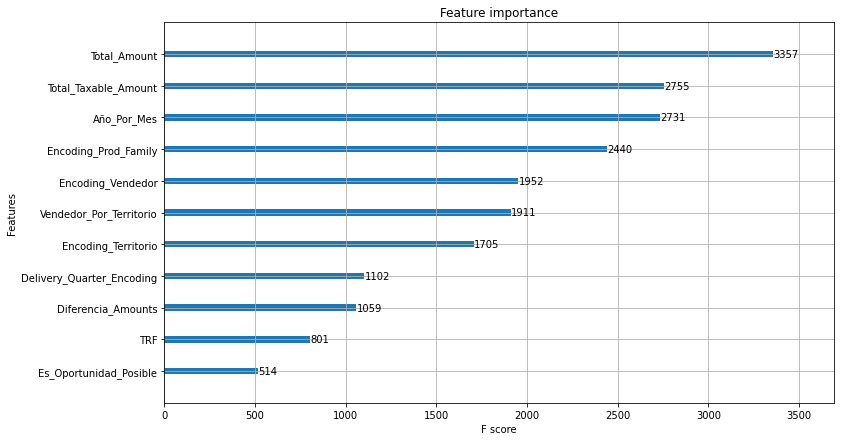

In [766]:
plt.rcParams['figure.figsize'] = [12, 7]
xgb.plot_importance(xg_reg)